# Fraudulent Job Postings

### Author: Mellissa Valle

12/09/2021

## Overview

Can’t tell if a job posting is legit? Unfortunately, there are a lot of scammers out there that can and will take advantage of jobseekers. So if you think a job posting isn’t real, it probably isn’t, we humans can have an idea how to detect those, one by one. But how much time would it take a company like Indeed to accurately identify and take down thousands and thousands of fraudulent job postings? 

##### There are several reasons why fake job postings exist: 

- Some spammers who would get the jobseeker’s email address and then sell it to other individuals. 
- And lastly the Scammers, criminals who want to steal money or even the individual’s identity.

## Business Understanding

The hiring process has relatively recently been moved to the cloud. Specifically, the automated systems responsible for completing the recruitment of new employees in an online fashion, to make the hiring process faster and cost-efficient. However, the online exposure of such traditional business procedures has introduced new points of failure, the increasing adoption of online applications also attracts the interest of scammers. Putting at risk not only the job seekers’ privacy but also the credibility of organizations such as Indeed, Monster, CareerBuilder, etc.

![image4](https://pngimage.net/wp-content/uploads/2018/06/online-logo-png-6.png)

## Data Understanding

Dataset from : [Kaggle.com](https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction) download and save on a `Data` folder 

Acknowledgements

The University of the Aegean | Laboratory of Information & Communication Systems Security
[emscad.samos.aegean](http://emscad.samos.aegean.gr/)

Dataset used for modeling contains 17,014 legitimate and 866 fraudulent job ads (17,880 in total). All the entries were manually annotated by specialized human employees.The criteria for the classification were based on the client's suspicious activity on the system, false contact or company information, candidate complaints and periodic meticulous analysis of the clientele.

The second dataset was originally scrapped from Indeed.com and it contains 3002 records, all from the USA.

In [1]:
# Load required libraries

#Exploratory 
import pandas as pd
import numpy as np
import missingno

#Data Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# sklearn
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline


#Preprocessing
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import word_tokenize
import string
import re

#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


#Data Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB



#Data Evaluation 

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, \
                                    cross_validate , \
                                    GridSearchCV, \
                                    cross_val_predict

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')

#Mellissas utils
from utils import *

# Set the same random_state
seed = 29

In [2]:
df = pd.read_csv('Data/fake_job_postings.csv', index_col=0)
df.head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


#### Functions :

In [3]:
# Taken from: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/ 

# Custom transformer 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

<AxesSubplot:>

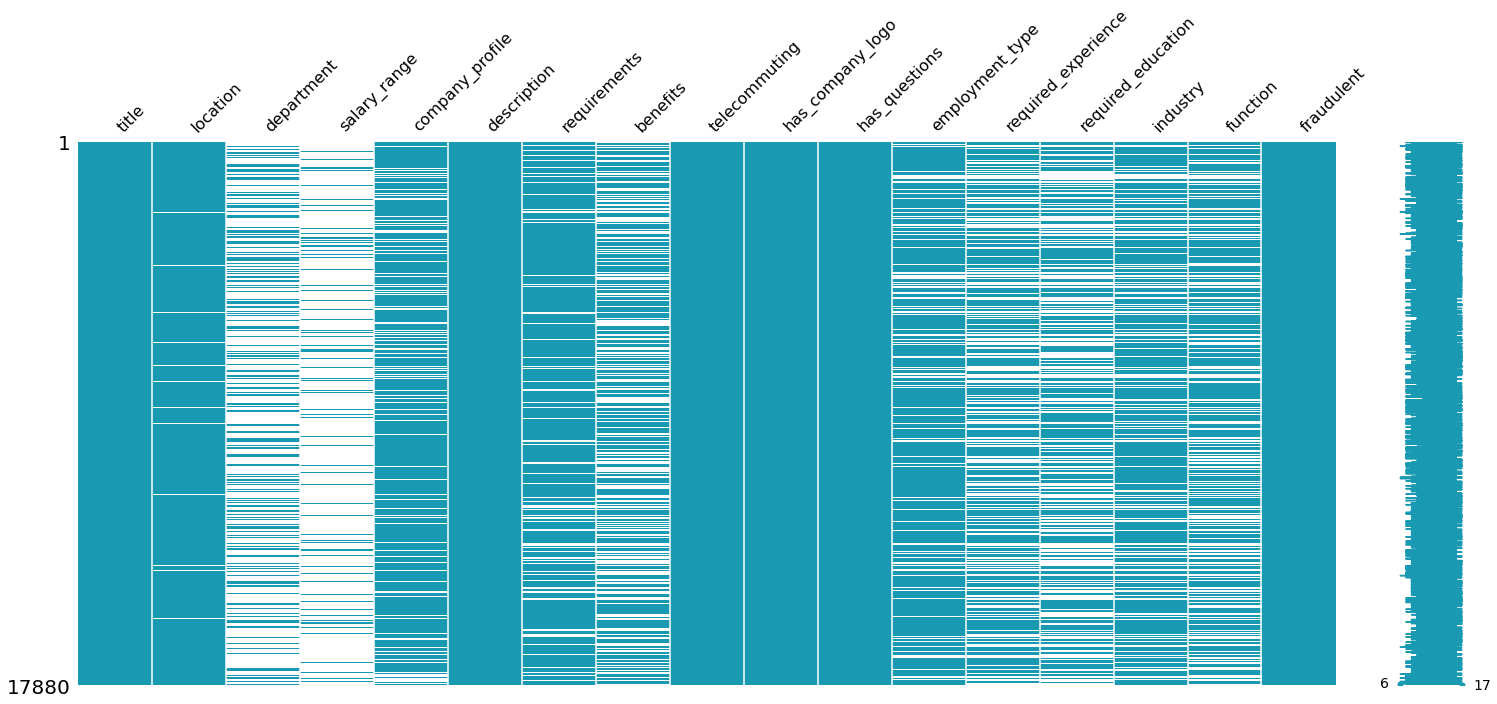

In [4]:
# checking missing data in our dataframe.
missingno.matrix(df,color=(0.1, 0.6, 0.7))

- Dataset contains lots of missing values which need to be taken care of.

### Target
- Fraudulent

In [5]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

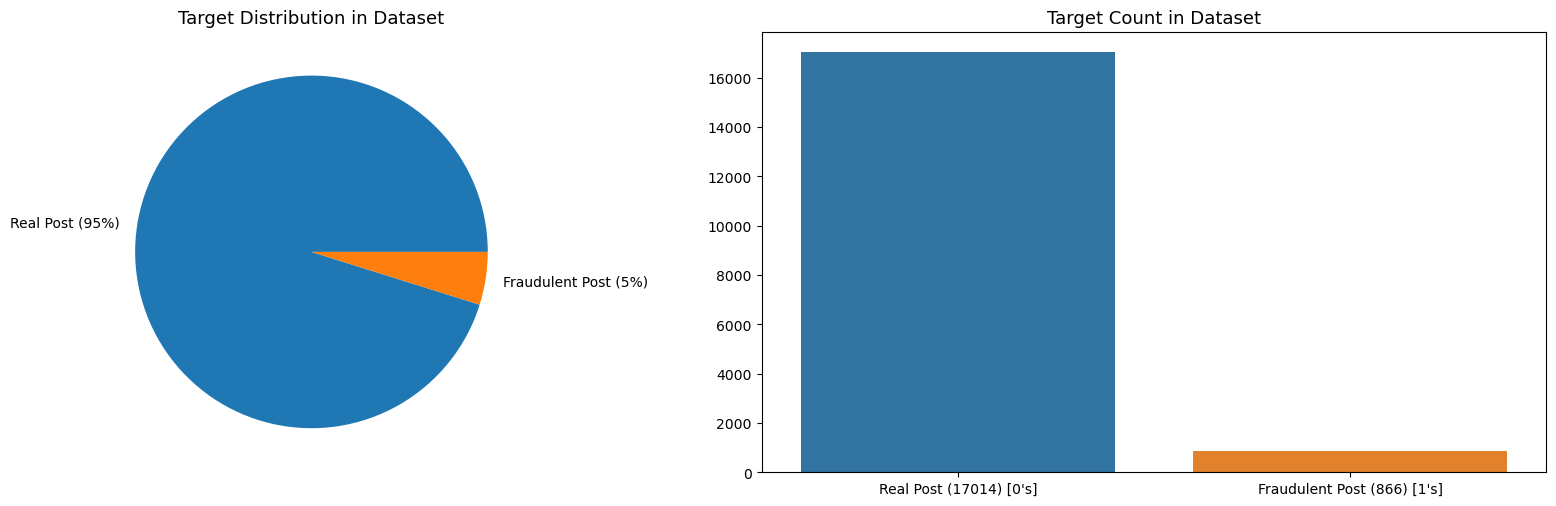

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100,)
plt.tight_layout()

df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fraudulent Post (5%)'])
temp = df["fraudulent"].value_counts()
sns.barplot(temp.index, temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fraudulent Post (866) [1's]"])

axes[0].set_title('Target Distribution in Dataset', fontsize=13)
axes[1].set_title('Target Count in Dataset', fontsize=13)

plt.show()

- First Row

In [7]:
# new cols to check nulls
df['has_benefit'] = pd.notnull(df["benefits"])
df['has_requirements'] = pd.notnull(df["requirements"])
df.head(1)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements
job_id,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,False,True


## Data Prep

In [8]:
df.location.isna().sum()

346

In [9]:
# Location
df['location'] = df['location'].fillna(' ')
df['location'] = df['location'].apply(lambda x: x[3:6] )
df['location'] = df['location'].replace(' , ','unknown' )

### Dealing with missing values 

In [10]:
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'has_benefit', 'has_requirements'],
      dtype='object')

In [11]:
# Fill nulls with 'no benefit listed'
df['benefits'] = df['benefits'].fillna('no benefit listed')

# Fill nulls with 'no requirement listed'
df['requirements'] = df['requirements'].fillna('norequirementlisted')

# Fill nulls with 'no description listed'
df['description'] = df['description'].fillna('unknown')

# Fill nulls with 'no required_experience listed'
df['required_experience'] = df['required_experience'].fillna('unknown')

# Fill nulls with 'no company_profile listed'
df['company_profile' ]= df['company_profile'].fillna('unknown')

# Fill nulls with 'no companylogo'
df.has_company_logo.replace({0:"nocompanylogo",1:'hascompanylogo'},inplace=True)

## Categoricals

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


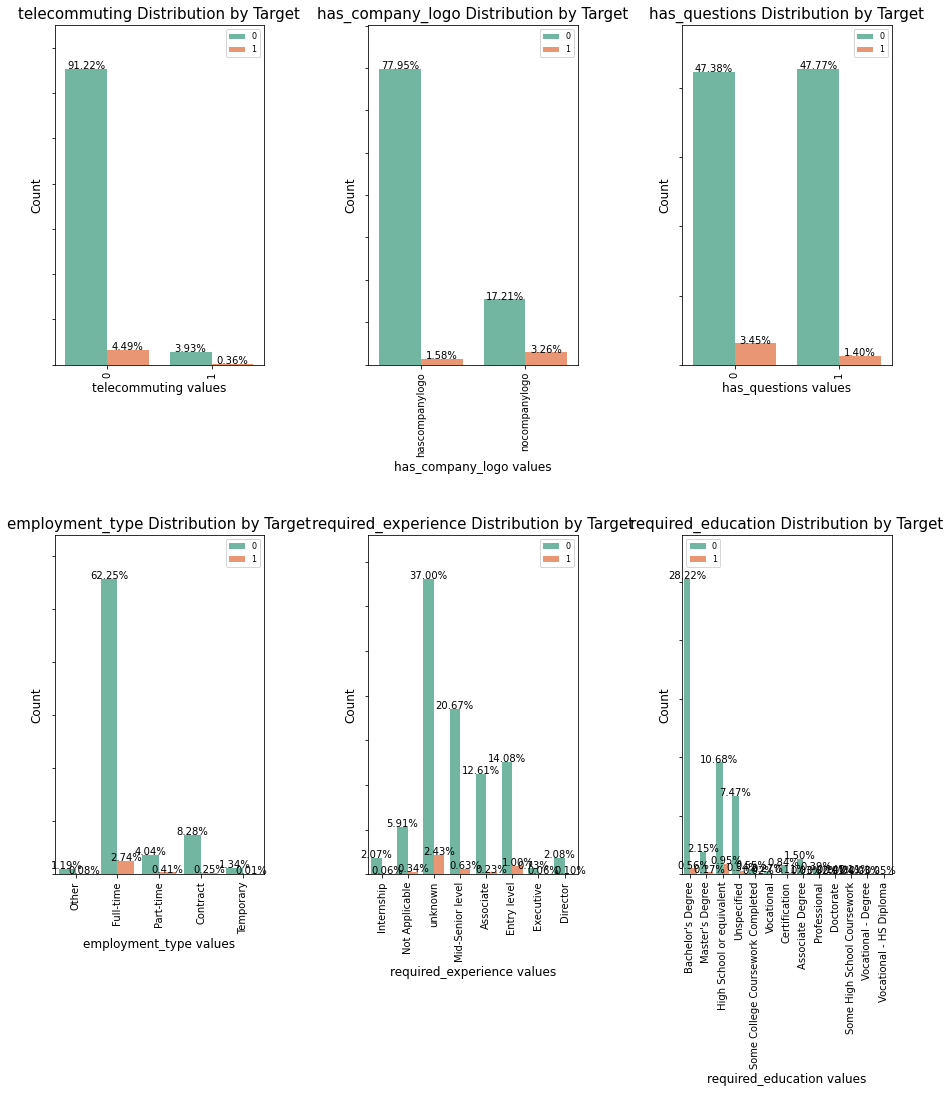

In [12]:
cat_df = df[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function","fraudulent"]]
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education",]
# visualizating categorical variable by target
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5) # The grid of chart
plt.figure(figsize=(15,25)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(cat_df[cat_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=cat_df, hue='fraudulent', palette='Set2') 
    ax.set_ylabel('Count', fontsize=12) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=15) # title label
    ax.set_xlabel(f'{col} values', fontsize=12) # x axis label
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels() 
    ax.set_xticklabels(xlabels,  fontsize=10)
    ax.set_yticklabels(ylabels,  fontsize=10)
    plt.legend(fontsize=8)
    plt.xticks(rotation=90) 
    total = len(cat_df)
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=10) 
    ax.set_ylim(0, max(sizes) * 1.15) #set y limit based on highest heights


plt.show();

- From these graphs it looks like having company logo is an important feature

 ### Combining our text data in a single column to start the cleaning  process

In [13]:
# merging all relevant cols to one `text`
df['text'] = '  '+ df['title'] +'  '+ df['description'] +'  '+ df['requirements']+'  '+ \
                   df['benefits']+'  '+ df['required_experience'] + '  ' + df['has_company_logo' ] + '  ' + \
                   df['company_profile' ] + '  '
df.head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements,text
job_id,,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,NY,Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,no benefit listed,0,hascompanylogo,0,Other,Internship,NaN,NaN,Marketing,0,False,True,"Marketing Intern Food52, a fast-growing, Ja..."
2,Customer Service - Cloud Video Production,unknown,Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,hascompanylogo,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,True,True,Customer Service - Cloud Video Production O...


In [14]:
# types of words are frequent in fraudulent and not fraudulent

fraud_jobs_text = df[df.fraudulent==1].text
actual_jobs_text = df[df.fraudulent==0].text

In [15]:
actual_jobs_text.value_counts().sum()

17014

In [16]:
fraud_jobs_text.value_counts().sum()

866

# WordCloud

## Fraudulent Words!!!  X

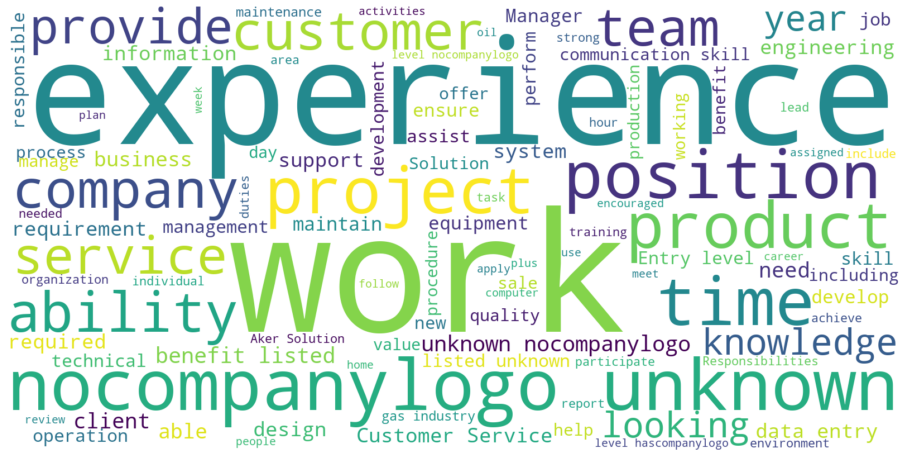

In [17]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800,
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(fraud_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

## Not Fraudulent Words! lol ✓

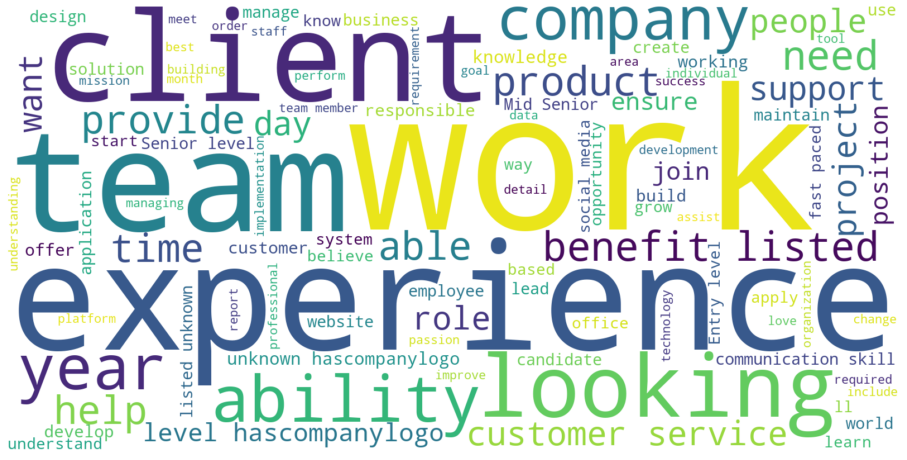

In [18]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800, 
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(actual_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

## Data Cleaning

In [19]:
# only need target and text
data = df[["fraudulent", "text"]]
data

,fraudulent,text
job_id,,
1,0,"Marketing Intern Food52, a fast-growing, Ja..."
2,0,Customer Service - Cloud Video Production O...
3,0,Commissioning Machinery Assistant (CMA) Our...
4,0,Account Executive - Washington DC THE COMPA...
5,0,Bill Review Manager JOB TITLE: Itemization ...
...,...,...
17876,0,Account Director - Distribution Just in ca...
17877,0,Payroll Accountant The Payroll Accountant w...
17878,0,Project Cost Control Staff Engineer - Cost C...


Taken from: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

In [20]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

## Remove punctionation and numbers, and turn lowercase

In [21]:
# Apply to the DF series
data.text = data.text.apply(remove_punctuations)

In [22]:
#remove weird numbers
data.text = data.text.apply(remove_number)
data.text

job_id
1          Marketing Intern  Food    a fast growing  Ja...
2          Customer Service   Cloud Video Production  O...
3          Commissioning Machinery Assistant  CMA   Our...
4          Account Executive   Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE  Itemization ...
                               ...                        
17876      Account Director   Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer   Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we Vend ...
Name: text, Length: 17880, dtype: object

- All punctuations removed, next turn all lowercase


In [23]:
# All lowercase
data.text = data.text.str.lower()
# Adding State last to keep it Caps
data.text = data['text'] +'  '+ df['location']+'  '

#### WordCloud Clean

In [24]:
# types of words are frequent in fraudulent and not fraudulent

fraud_jobs_text = data[data.fraudulent==1].text
actual_jobs_text = data[data.fraudulent==0].text

In [25]:
actual_jobs_text

job_id
1          marketing intern  food    a fast growing  ja...
2          customer service   cloud video production  o...
3          commissioning machinery assistant  cma   our...
4          account executive   washington dc  the compa...
5          bill review manager  job title  itemization ...
                               ...                        
17876      account director   distribution   just in ca...
17877      payroll accountant  the payroll accountant w...
17878      project cost control staff engineer   cost c...
17879      graphic designer  nemsia studios is looking ...
17880      web application developers  who are we vend ...
Name: text, Length: 17014, dtype: object

### Fraudulent Jobs Ads text

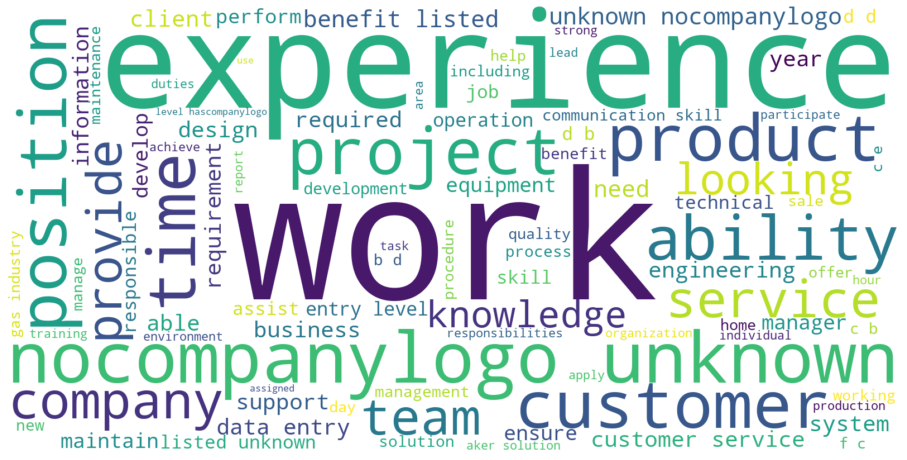

In [26]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 90, 
               width = 1600, 
               height = 800,
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(fraud_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

Attention to: nocompanylogo, unknown

### Legitimate Job Ads text

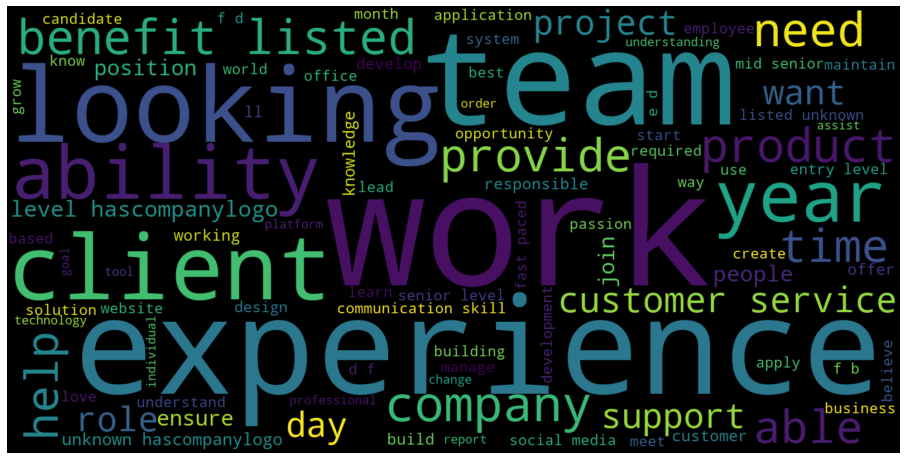

In [27]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 90, 
               width = 1600, 
               height = 800, 
               background_color='black',
               stopwords = STOPWORDS).generate(str(" ".join(actual_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

Attention to: team, client, year, hascompanylogo

In [28]:
# creating our bag of words
bow_vector = CountVectorizer(tokenizer = word_tokenize, ngram_range=(1,3),lowercase=True)
bow_vector

CountVectorizer(ngram_range=(1, 3),
                tokenizer=<function word_tokenize at 0x7f90fd19ca60>)

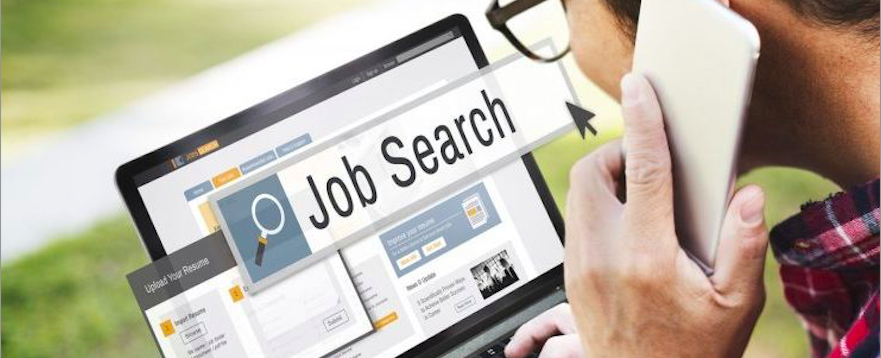

# Machine Learning -> Modelling

Models to try:

- Logistic Regression
- Random Forest Classifier
- XGBoost Classifier
- Tuned Logistic Regression

For more models check [Machine_Learning_Models](https://github.com/MellissaValle/Fraudulent-Job-Postings/blob/main/Notebooks/Machine_Learning_Models.ipynb) from same repo

In [29]:
# splitting our data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, 
                                                    test_size=0.25, random_state=seed)

In [30]:
y_train.value_counts()

0    12731
1      679
Name: fraudulent, dtype: int64

## First Baseline Model LogisticRegression

In [31]:
clf = LogisticRegression(random_state=seed)

# Create pipeline using Bag of Words
pipe = Pipeline([('cleaner', predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f9090147d00>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f90fd19ca60>)),
                ('classifier', LogisticRegression(random_state=29))])

In [32]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))
print("Logistic Regression Recall:", recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9874720357941834
Logistic Regression Recall: 0.7219251336898396


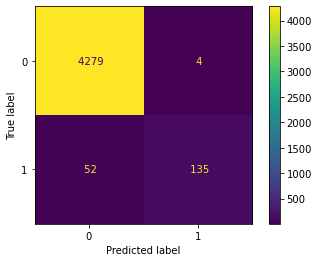

In [33]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      values_format=' ')

## Random Forest

In [34]:
clf = RandomForestClassifier(random_state=seed)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f90e51be7f0>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f90fd19ca60>)),
                ('classifier', RandomForestClassifier(random_state=29))])

In [35]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, predicted))
print("Random Forest Recall:", recall_score(y_test, predicted))

Random Forest Accuracy: 0.9838926174496644
Random Forest Recall: 0.6149732620320856


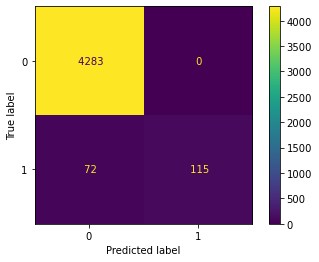

In [36]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      values_format=' ')

# Dealing with Imbalance Oversampling

## CountVectorizer and over

In [37]:
imb_log_model = imbpipe(steps=[
                         ('vectorizer', CountVectorizer(stop_words=stop_words)),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1,random_state=seed))])
# fitting the model
imb_log_model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('LR', LogisticRegression(C=0.1, random_state=29))])

In [38]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9776286353467561
Recall: 0.8181818181818182


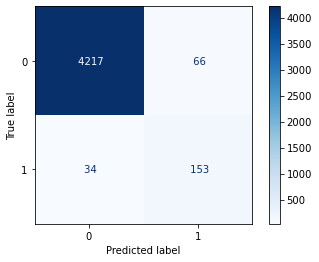

In [39]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

- CountVectorizer and RandomOverSampler looks good. This is our best model and can go ahead and test our Indeed dataset to get predictions, unless undersampling gives better results

## Undersampling 

## CountVectorizer

In [40]:
under_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('LR',LogisticRegression(random_state=seed))])

# fitting the model
under_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('LR', LogisticRegression(random_state=29))])

In [41]:
# Predicting with a test
predicted = under_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9114093959731544
Recall: 0.8983957219251337


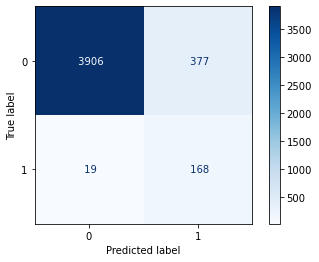

In [42]:
plot_confusion_matrix(under_log_model, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

- This model does minimize the false negatives, but does it reduce enough to justify the overall decrease in accuracy? No! 
Whereas CountVectorizer and RandomOverSampler still doesn’t have a ton of false negatives, helps cut down on human labor given the overall better accuracy

## Testing Indeed Dataset !!

![Image4.png](https://scontent.fsjo7-1.fna.fbcdn.net/v/t1.6435-9/159365869_10158788359063381_8314091359123761615_n.png?_nc_cat=100&ccb=1-5&_nc_sid=e3f864&_nc_ohc=EY1KEgkwBBwAX-VLo9y&_nc_ht=scontent.fsjo7-1.fna&oh=b98cc65181a1d1bf5b5e208fd06f7617&oe=61D0ADA6)

### Best Model: Tuned Logistic Regression with CountVectorizer and RandomOverSampler

 Second dataset from Indeed here [Indeed Dataset](https://data.world/promptcloud/indeed-job-posting-dataset/workspace/project-summary?agentid=promptcloud&datasetid=indeed-job-posting-dataset) download and save into a `Data` folder

In [43]:
indeed = pd.read_csv('Data/indeed', index_col=0)
indeed.head()

,text
0,shift manager id we are lookin...
1,operations support manager id ...
2,senior product manager data id ...
3,part time office concierge id ...
4,print marketing associate id ...


In [44]:
# text from indeed to predict
test = indeed.text

In [45]:
# Prediction on indeed text
y_preds_indeed = imb_log_model.predict(test)

In [46]:
# Labelling 
indeed['Label'] = pd.Series(y_preds_indeed)

In [47]:
indeed

,text,Label
0,shift manager id we are lookin...,0
1,operations support manager id ...,0
2,senior product manager data id ...,0
3,part time office concierge id ...,1
4,print marketing associate id ...,0
...,...,...
29997,bilingual teller id a little a...,0
29998,rental consultant harrison oh id ...,1
29999,product support specialist id ...,0
30000,marketing strategist contract id ...,0


My model predicts 29998 is fraudulent. Let's take a look why that might be:
- Post has no company logo or company profile
- Description is short

In [48]:
indeed.loc[29998].text

'  rental consultant   harrison  oh    id              self storage rental consultant   full time   harrison  oh    locally owned self storage company is seeking a full time rental consultant for our harrison  ohio location  candidates should have prior experience in sales  marketing  or customer service  this position requires close attention to detail  basic math and computer skills and a positive energetic personality  the ability to be a self starter  work independently and be accountable to management is a must     duties include     lease storage units to customers    convey features of the storage facility to the customer    direct customer toward correct size of storage unit    correctly execute all leasing documents    learn computer software  complete general accounting tasks  and produce daily management reports    maintain office files and order all office supplies    keep property and office clean and organized    perform light maintenance around storage facility    perfor

In [49]:
indeed.Label.value_counts()

0    28743
1     1259
Name: Label, dtype: int64

## Indeed Predictions

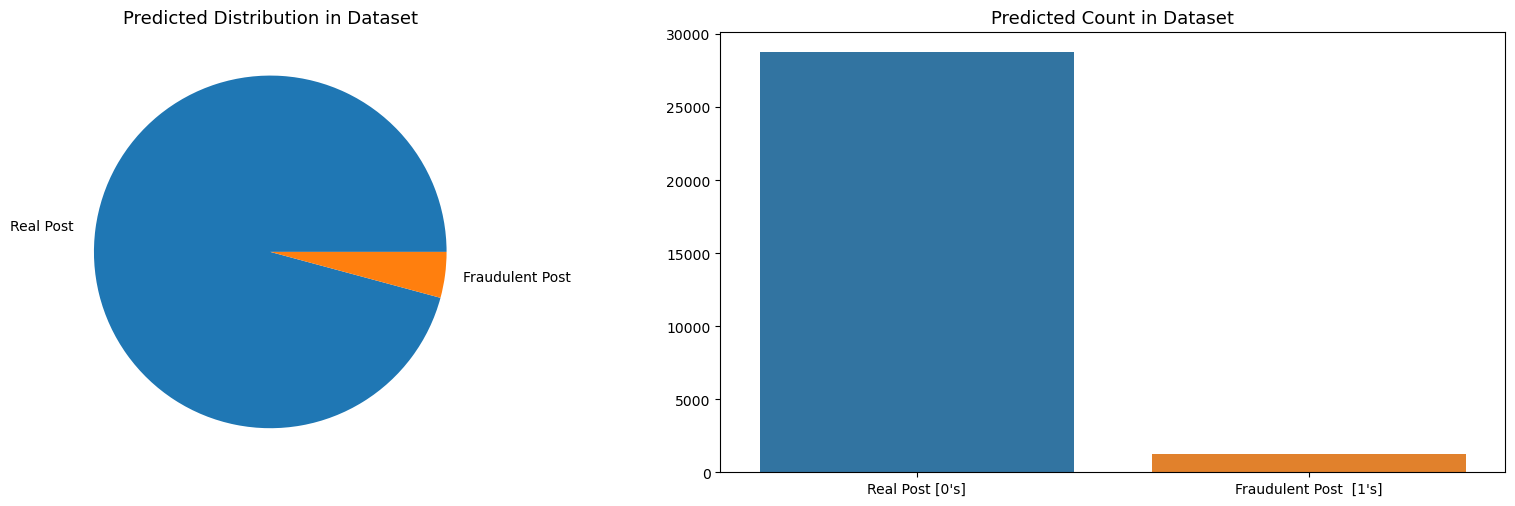

In [50]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100,)
plt.tight_layout()

indeed['Label'].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post ', 'Fraudulent Post'])
temp = indeed['Label'].value_counts()
sns.barplot(temp.index, temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post [0's]", "Fraudulent Post  [1's]"])

axes[0].set_title('Predicted Distribution in Dataset', fontsize=13)
axes[1].set_title('Predicted Count in Dataset', fontsize=13)

plt.show()

## Conclusion

Key words: Reduction in time! With this model, the process of detecting fake job postings would be much quicker. Indeed must have some kind of mechanism to find these fraudulent posts, but it probably takes a while. This model analyzes the job posts and flags those that are predicted to be fake/fraudulent, making this process of flagging much faster. 

This model will not detect immediately which ones are fraudulent to 100% but it will make it a lot easier. Instead of going through 30k I hope I only have to go through a few thousands.

From the Indeed dataset, my model predicted: 

- Not fraudulent 28743 and to be Fraudulent 1259
- Accuracy: 97.673% and Recall: 81.818%

### Possible Next Steps

- Add industry and department features with SelectBox
- Test datasets from different Job Search Sites
- Add a second language Spanish